In [230]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.10.0


In [231]:
GRAIN_TYPE = 'Wheat'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
df = df.groupby('Variety').head(120)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Variety']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [232]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Variety'].nunique()
varieties = df_targets['Variety'].unique()
print(f'There are {num_varieties} different varieties.')

# Encode the 'variety' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Variety'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different varieties.


In [233]:
# Perform train-test split on RAW DATA
X_train, X_test, y_train, y_test = train_test_split(dataset_x, y_one_hot, test_size=0.20,random_state=42)
#validation split
#X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.15, random_state=42)


In [234]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define model
model = tf.keras.Sequential([
    Dense(128, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(5, activation='softmax')  # Changed to softmax for multi-class
])

# Compile model with per-class precision and recall
metrics = ['accuracy']  # General accuracy for all classes

# Add precision and recall for each class
for i in range(depth):
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=f'precision_class_{i}'))
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=f'recall_class_{i}'))

model.compile(
    loss='categorical_crossentropy',  # Correct loss for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),  
    metrics=metrics
)
history = model.fit(X_train, y_train, epochs=900, batch_size=32)
model.save(FILENAME_BEST_MODEL)

Epoch 1/800
16/16 [==============================] - 0s 883us/step - loss: 1.5697 - accuracy: 0.3549 - precision_class_0: 0.0000e+00 - recall_class_0: 0.0000e+00 - precision_class_1: 0.0000e+00 - recall_class_1: 0.0000e+00 - precision_class_2: 0.0000e+00 - recall_class_2: 0.0000e+00 - precision_class_3: 0.0000e+00 - recall_class_3: 0.0000e+00 - precision_class_4: 0.0000e+00 - recall_class_4: 0.0000e+00
Epoch 2/800
16/16 [==============================] - 0s 754us/step - loss: 1.4704 - accuracy: 0.4745 - precision_class_0: 0.0000e+00 - recall_class_0: 0.0000e+00 - precision_class_1: 0.0000e+00 - recall_class_1: 0.0000e+00 - precision_class_2: 0.0000e+00 - recall_class_2: 0.0000e+00 - precision_class_3: 0.0000e+00 - recall_class_3: 0.0000e+00 - precision_class_4: 1.0000 - recall_class_4: 0.0707  
Epoch 3/800
16/16 [==============================] - 0s 856us/step - loss: 1.3929 - accuracy: 0.4431 - precision_class_0: 0.0000e+00 - recall_class_0: 0.0000e+00 - precision_class_1: 0.0000e+00 

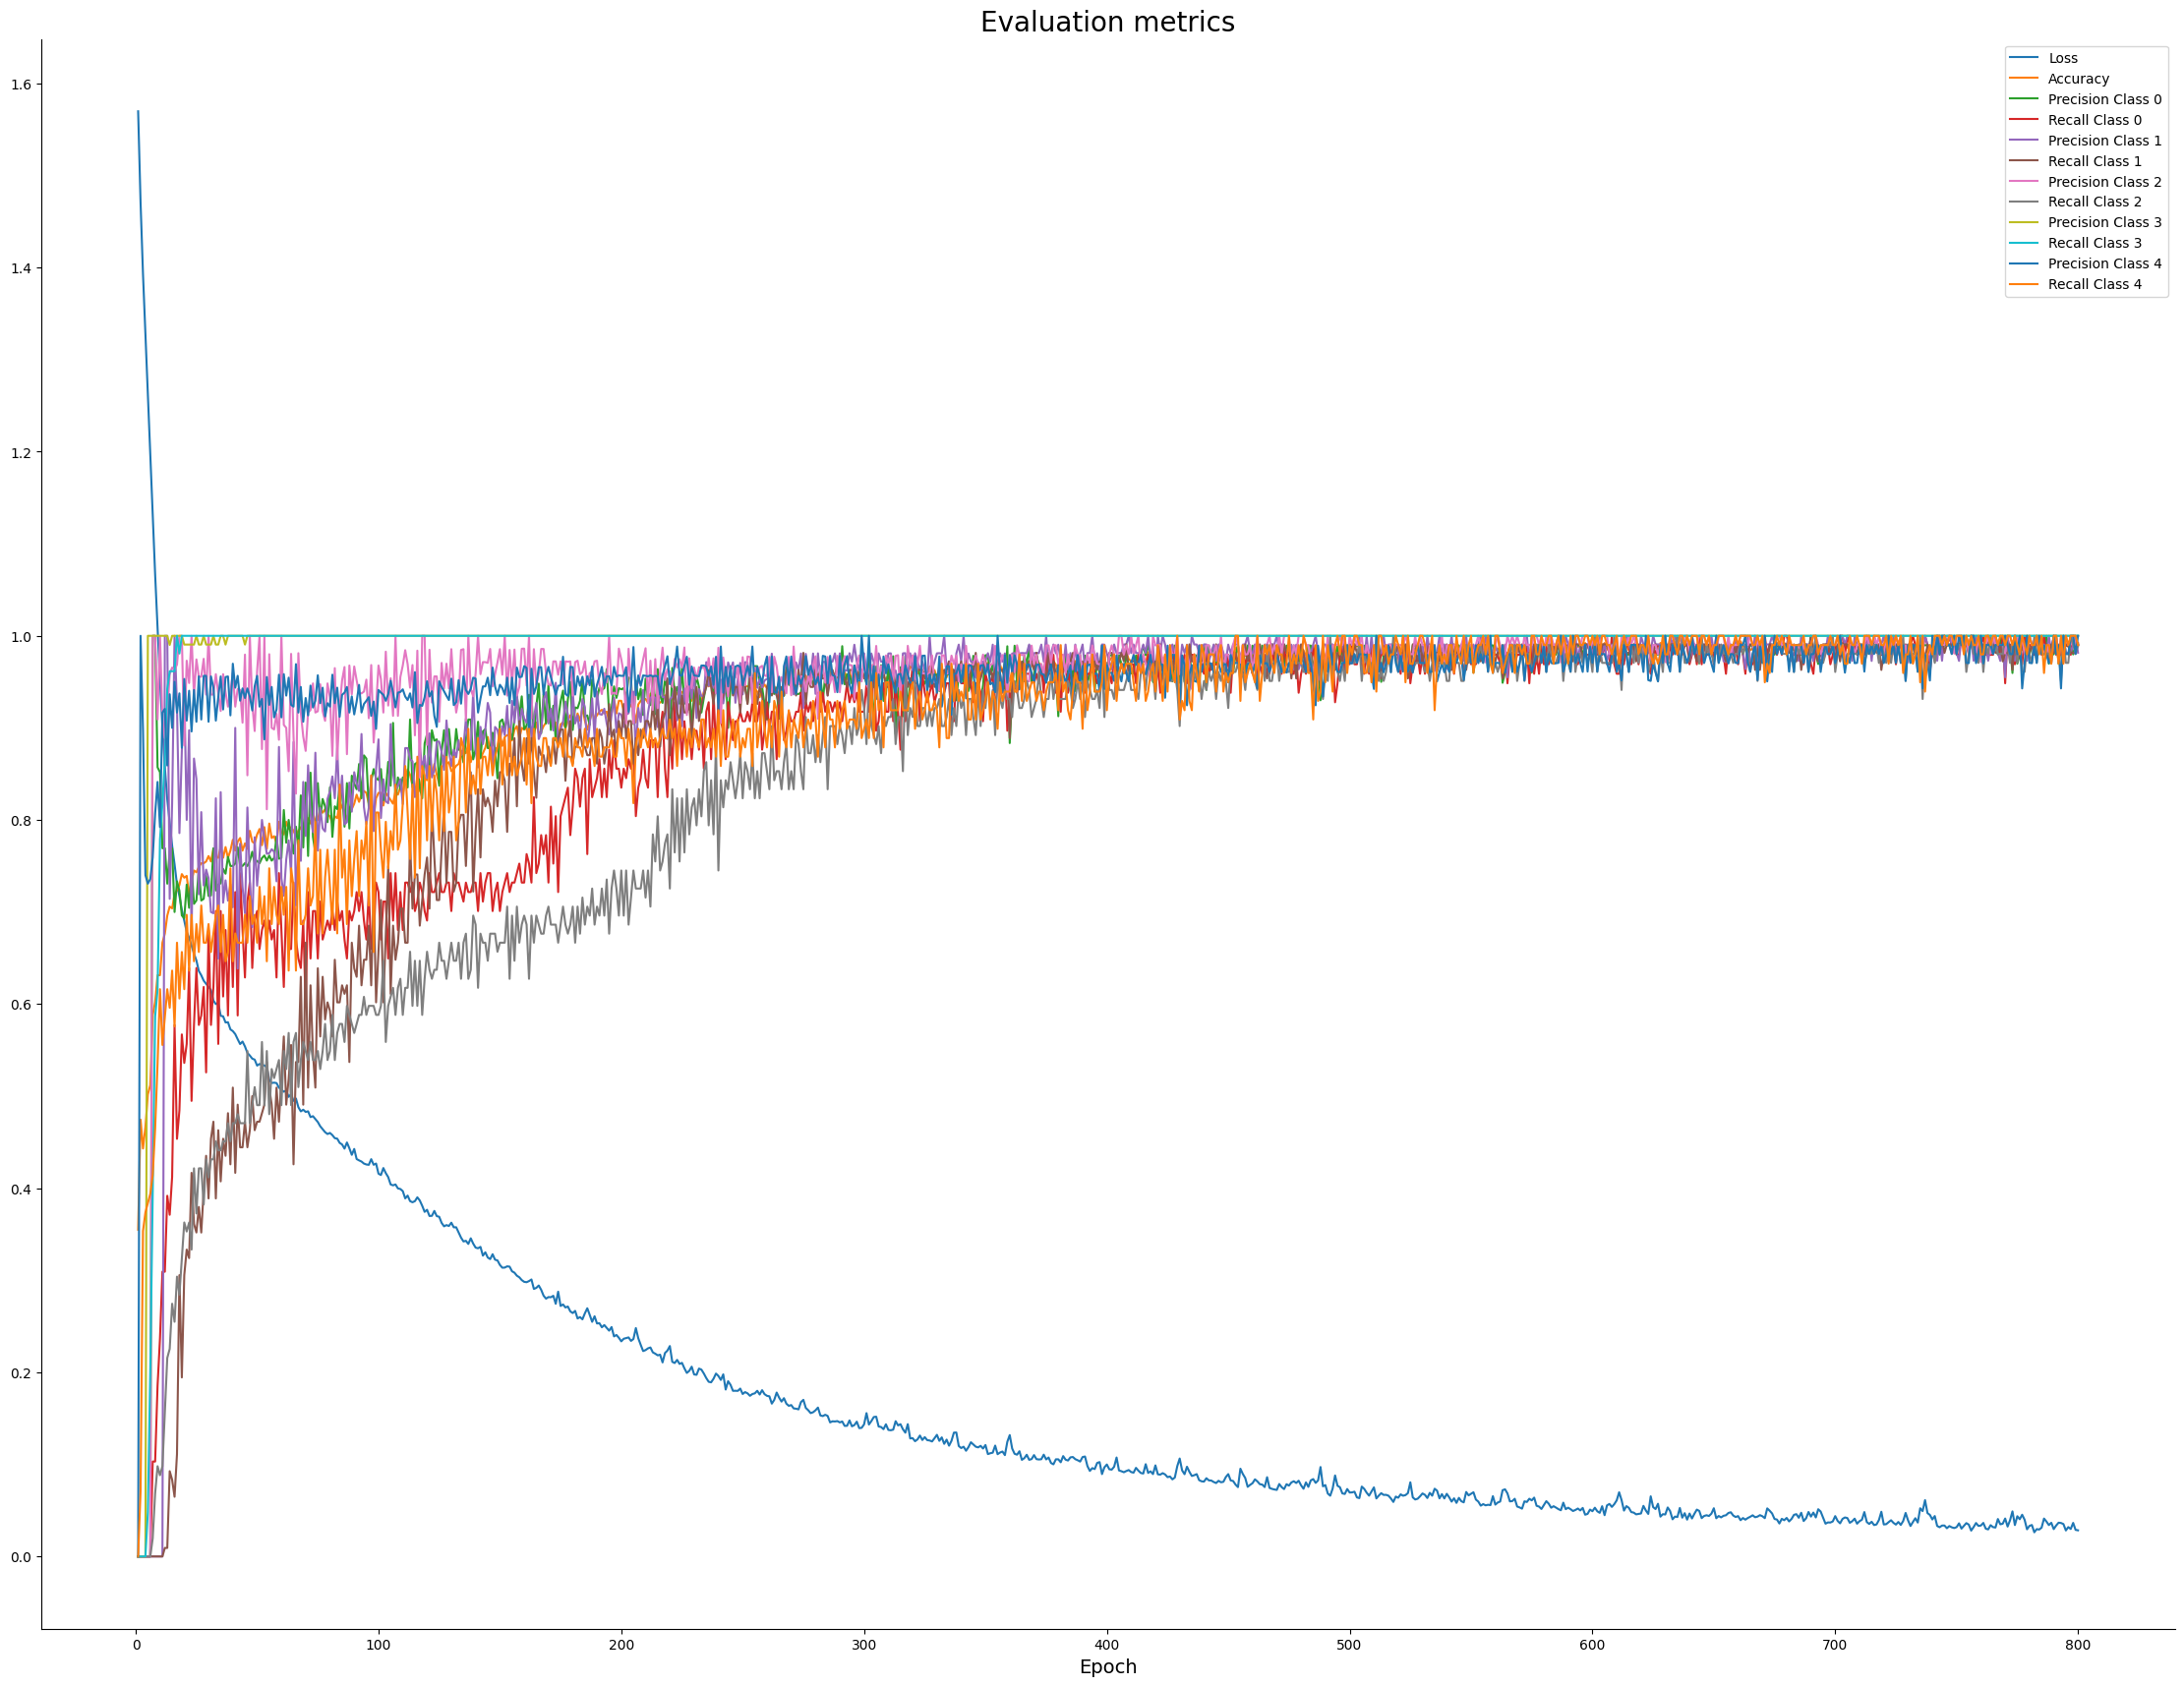

In [235]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()


In [236]:
# Evaluate the model on the test data
test_loss, test_accuracy, *test_metrics = model.evaluate(X_test, y_test)

# Assuming the order of metrics is consistent with how we added them:
# test_metrics[0] -> precision_class_0, test_metrics[1] -> recall_class_0, etc.
metrics_per_class = {
    'Loss': test_loss,
    'Accuracy': test_accuracy,
}

num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    metrics_per_class[f'Precision Class {i}'] = test_metrics[2 * i]  # Even indices
    metrics_per_class[f'Recall Class {i}'] = test_metrics[2 * i + 1]  # Odd indices

# Display the metrics for each class
for metric_name, metric_value in metrics_per_class.items():
    print(f'{metric_name}: {metric_value:.4f}')


3/3 [==============================] - 0s 977us/step - loss: 0.4967 - accuracy: 0.8889 - precision_class_0: 0.9130 - recall_class_0: 0.9130 - precision_class_1: 0.8333 - recall_class_1: 0.8333 - precision_class_2: 0.8235 - recall_class_2: 0.7778 - precision_class_3: 1.0000 - recall_class_3: 1.0000 - precision_class_4: 0.8571 - recall_class_4: 0.8571
Loss: 0.4967
Accuracy: 0.8889
Precision Class 0: 0.9130
Recall Class 0: 0.9130
Precision Class 1: 0.8333
Recall Class 1: 0.8333
Precision Class 2: 0.8235
Recall Class 2: 0.7778
Precision Class 3: 1.0000
Recall Class 3: 1.0000
Precision Class 4: 0.8571
Recall Class 4: 0.8571
